#I. Machine Prep

In [60]:
%pip install pandas
!apt install graphviz libgraphviz-dev
%pip install pygraphviz
%pip install powerlaw
%pip install networkx

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [61]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import accuracy_score, auc
import pprint
import numpy as np
from collections import OrderedDict
import powerlaw
import itertools as it
from typing import Dict, Set, Tuple
from scipy.optimize import minimize
import copy
from pprint import pprint

#II. Pedigree Graph Conversion

In [62]:
def pedfile_readin(pedfile):
    cols = ['FamilyID', 'IndividualID', 'PaternalID', 'MaternalID', 'Sex', 'Phenotype', 'Genotype']
    df = pd.read_csv(pedfile, sep=r'\s+', header=None, names=cols)
    return df


def construct_pedigree_graph(df, rm_floaters= True):
    G = nx.DiGraph()

    all_parents_set = set()
    founder_set = set()

    for _, row in df.iterrows():
        # Make sure IndividualID is treated as a string or int consistently if needed
        G.add_node(row['IndividualID'],
                  family=row['FamilyID'],
                  sex=row['Sex'],
                  phenotype=row['Phenotype'])

    for _, row in df.iterrows():
        # Ensure PaternalID and MaternalID are compared to string '0' if they are strings
        paternal_id = row['PaternalID']
        maternal_id = row['MaternalID']
        individual_id = row['IndividualID']

        if paternal_id != 0:
            G.add_edge(paternal_id, individual_id)
            all_parents_set.add(paternal_id)
        if maternal_id != 0:
            G.add_edge(maternal_id, individual_id)
            all_parents_set.add(maternal_id)
        if maternal_id == 0 and paternal_id == 0:
            founder_set.add(individual_id)

    #Removing founders with no children (i.e. floaters)
    if rm_floaters:
        floaters_set = founder_set - all_parents_set
        G.remove_nodes_from(floaters_set)


    return G

###Pedigree Graph Visualization

In [63]:
def plot_pedigree_tree(G, title="Pedigree (Tree Layout)"):
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        pos = graphviz_layout(G, prog='dot')  # 'dot' gives top-down DAG style
    except ImportError:
        print("PyGraphviz not installed. Falling back to spring layout.")
        pos = nx.spring_layout(G, seed=42)

    node_colors = ['red' if G.nodes[n]['phenotype'] == 2 else 'lightblue' for n in G.nodes]

    nx.draw(G, pos, with_labels=True, node_color=node_colors, arrows=True)
    plt.title(title)
    plt.show()

#III. Pedigree Graph Analysis

###Simple Pedigree Helper Functions

In [64]:
def parents(G, node):
    """Return a list of parent nodes for `node` (incoming edges)."""
    return list(G.predecessors(node))

def siblings(G, node):
    """Return siblings: nodes that share ≥ 1 parent with `node`."""
    sibs = set()
    for p in parents(G, node):
        sibs.update(G.successors(p))
    sibs.discard(node)
    return sibs

def children(G, node):
    """Return a list of child nodes for `node` (outgoing edges)."""
    return list(G.successors(node))

def generations(G):
    lvl={}
    Q=[(n,0) for n in G if G.in_degree(n)==0]
    while Q:
        n,d=Q.pop(0)
        #this check doesnt take into account children produced from one founder and one relative
        #leads all individuals to have the generation count to be minimum distance from most recent founder
        #if n in lvl: continue
        lvl[n]=d
        for c in G.successors(n): Q.append((c,d+1))
    return lvl

def aff(G):
    return [n for n in G.nodes if G.nodes[n]['phenotype']==2]
def unaff(G):
    return [n for n in G.nodes if G.nodes[n]['phenotype']==1]


###Pedigree Feature Extraction and Metric Calculation

In [65]:
#################### MODULAR PEDIGREE FEATURES ####################
'''
Features: measures based on inheritence patterns gleaned from pedigree data alone,
no use of genotype or graph-specific data

Current List of Features:
-------------------------
1. Ratio Affected Parents
2. Generation Coverage
3. Affected Sibling Clustering
4. Average Betweeness of Unaffected
5. Average Betweeness of Carriers (CURRENTLY EXCLUDED)
6. Average Betweeness of Carriers in Affected+Carrier Subgraph (CURRENTLY EXCLUDED)
'''

# ---------------------------------------------------------------------
# 1. Ratio Affected Parents
# ---------------------------------------------------------------------
def ratio_aff_parents(G):
    aff_nodes = aff(G)
    aff_aff_partent = 0
    for n in aff_nodes:
        if any(G.nodes[p]['phenotype']==2 for p in parents(G,n)):
            aff_aff_partent +=1
    return aff_aff_partent/len(aff_nodes) if aff_nodes else 0


# ---------------------------------------------------------------------
# 2. Generation Coverage
# ---------------------------------------------------------------------
def gen_cov(G):
    gen = generations(G)
    gens_aff = {gen[n] for n in aff(G)}
    return len(gens_aff)/(max(gen.values())+1) if gen else 0


# ---------------------------------------------------------------------
# 3. Affected Sibling Clustering
# ---------------------------------------------------------------------
def sibling_aff_ratio(G):
    sib_pairs=0; aa_pairs=0
    for n in aff(G):
        for sib in siblings(G,n):
            if sib in aff(G):
                aa_pairs+=1
            sib_pairs+=1
    return aa_pairs/sib_pairs if sib_pairs else 0


# ---------------------------------------------------------------------
# 4. Average Betweeness of Unaffected
# ---------------------------------------------------------------------
def avg_bet_unaff(G):
    unaffecteds = unaff(G)
    bet = nx.betweenness_centrality(G)
    return np.mean([bet[n] for n in unaffecteds]) if unaffecteds else 0


# ---------------------------------------------------------------------
# 5. Average Betweeness of Carriers
# ---------------------------------------------------------------------
'''
Currently defunct based on necessary inclusion of genotype data
which is not included in pedigree graph alone
'''
# def avg_bet_carrier(G):
#     carriers = [n for n in unaff(G) if G.nodes[n]['phenotype'] == 1]
#     bet = nx.betweenness_centrality(G)
#     return np.mean([bet[n] for n in carriers]) if carriers else 0


# ---------------------------------------------------------------------
# 6. Average Betweeness of Carriers in Affected+Carrier Subgraph
# ---------------------------------------------------------------------
'''
Currently defunct based on necessary inclusion of genotype data
which is not included in pedigree graph alone
'''
# def avg_bet_carrier_subgraph(G):
#     aff_nodes = aff(G)
#     unaff_nodes = unaff(G)
#     carrier_nodes = [n for n in unaff_nodes if G.nodes[n]['genotype'] == 1]
#     bet = nx.betweenness_centrality(G.subgraph(aff_nodes+carrier_nodes))
#     return np.mean([bet[n] for n in carrier_nodes]) if carrier_nodes else 0


# ---------------------------------------------------------------------
# PEDIGREE FEATURES WRAPPER
# ---------------------------------------------------------------------
def pedigree_features(G):
    return {
        'ratio_aff_parent': ratio_aff_parents(G),
        'gen_cov': gen_cov(G),
        'sibling_aff_ratio': sibling_aff_ratio(G),
        'avg_bet_unaff': avg_bet_unaff(G),

        # See exclusion reasoning in function description above
        #'avg_bet_carrier': avg_bet_carrier(G),
        #'avg_bet_carrier_subgraph': avg_bet_carrier_subgraph(G)
    }



In [66]:
#################### MODULAR GRAPH METRICS ####################
'''
Metrics: measures based on network structure and phenotype data independent of genotype data

Current List of Metrics:
-------------------------
1. Number of Nodes
2. Number of Edges
3. Number of Connected Components
4. Average Clustering Coefficient
5. Diameter
6. Average Shortest Path Length
7. Average Degree Centrality
8. Average Betweenness Centrality
9. Average Closeness Centrality
10. Power Law Alpha  (CURRENTLY EXCLUDED)
11. Power Law Xmin  (CURRENTLY EXCLUDED)
12. Sigma Small World (CURRENTLY EXCLUDED)
13. Pedigree Width
14. Number of Edges of Transitive Reduction
15. Transitive Reduction Size Ratio
16. Longest Path Length
17. Minimal Founder Coverage Size
18. Founder Influence
'''

# ---------------------------------------------------------------------
# 1. Basic Graph Metrics
# ---------------------------------------------------------------------
def basic_graph_metrics(G):
    G_u = G.to_undirected()
    return {
        'n_nodes': G.number_of_nodes(),
        'n_edges': G.number_of_edges(),
        'n_components': nx.number_connected_components(G_u),
        'avg_clustering': nx.average_clustering(G_u),
        'diameter': nx.diameter(G_u),
        'avg_path_len': nx.average_shortest_path_length(G_u)
    }

# ---------------------------------------------------------------------
# 2. Centralities
# ---------------------------------------------------------------------
def centralities(G):
    G_u = G.to_undirected()
    deg_cent = list(nx.degree_centrality(G_u).values())
    bet_cent = list(nx.betweenness_centrality(G_u).values())
    clos_cent = list(nx.closeness_centrality(G_u).values())

    return {'avg_degree_centrality': float(np.mean(deg_cent)),
            'avg_betweenness': float(np.mean(bet_cent)),
            'avg_closeness': float(np.mean(clos_cent))
    }

# ---------------------------------------------------------------------
# 3. Small-world Sigma
# ---------------------------------------------------------------------
'''
Currently unused given extreme computational bottleneck
'''
# def sigma_small_world(G):
#     # opted for plug-and-play sigma calculation from NetworkX over first principals calculation
#     # niter and nrand parameter values lowered to decrease computation time
#     return nx.sigma(G, niter= 1, nrand= 1)


# ---------------------------------------------------------------------
# 4. Power-law Exponent
# ---------------------------------------------------------------------
# '''
# Previously made use of full graph (floaters included),
# floater culling may have changed functionaly slightly
# '''
# def power_law_exponent(G):
#     degrees = [d for _, d in G.degree()]
#     fit = powerlaw.Fit(degrees, discrete=True, verbose=False)
#     return {
#         'pl_alpha': round(fit.power_law.alpha, 3),
#         'pl_xmin': fit.power_law.xmin
#         }

# ---------------------------------------------------------------------
# 5. Pedigree Width
# ---------------------------------------------------------------------
def pedigree_width(G: nx.DiGraph) -> int:
    if not nx.is_directed_acyclic_graph(G):
        raise ValueError("Graph must be a DAG.")
    #transitive closure creates new graph including all origianl edges and adding edges between all nodes connected by a path
    #i.e. for AD pedigree adds 4 edges connecting both grandparents to both of their grandchildren
    P = nx.algorithms.dag.transitive_closure(G)
    left  = {f"{n}_L" for n in G}
    right = {f"{n}_R" for n in G}
    B = nx.DiGraph()
    B.add_nodes_from(left,  bipartite=0)
    B.add_nodes_from(right, bipartite=1)
    for u, v in P.edges:
        B.add_edge(f"{u}_L", f"{v}_R")
    match = nx.algorithms.bipartite.maximum_matching(B, top_nodes=left)
    matched = len(match) // 2
    width = G.number_of_nodes() - matched
    return width

# ---------------------------------------------------------------------
# 6. Transitive Reduction Size
# ---------------------------------------------------------------------
# How does transitive reduction work with our pedigrees?
# nx.transitive_reduction only returns a list of duples for edges in transitive reduction
# would only cull child-parent relationships in cases of consanguinity between partent and other child
def dict_transitive_reduction_size(G):
    red = nx.transitive_reduction(G)
    return {'TR_n_edges': red.number_of_edges(),
            'TR_edge_ratio': red.number_of_edges()/G.number_of_edges()}

# ---------------------------------------------------------------------
# 7. Longest Path Length
# ---------------------------------------------------------------------
def longest_path_length(G):
    return nx.dag_longest_path_length(G)

# ---------------------------------------------------------------------
# 8. Minimal Founder Coverage
# ---------------------------------------------------------------------
def minimal_founder_cover_set(G: nx.DiGraph) -> set:
    """
    Return one minimal founder cover (greedy) as a Python set.
    """
    #different founder condition than used in score enhancement (no stipulation on genotype)
    founders = [n for n in G if G.in_degree(n) == 0]
    cover, uncovered = set(), set(G.nodes)
    while uncovered:
        best = max(founders, key=lambda f: len(nx.descendants(G, f) & uncovered) + (f in uncovered))
        cover.add(best)
        uncovered -= nx.descendants(G, best)
        uncovered.discard(best)
    return cover

def minimal_founder_coverage_size(G: nx.DiGraph) -> float:
    """
    Return the size of the minimal founder coverage set.
    """
    return len(minimal_founder_cover_set(G))

# ---------------------------------------------------------------------
# 9. Founder Influence
# ---------------------------------------------------------------------
def founder_influence(G) -> Dict[str, float]:
    phen = nx.get_node_attributes(G, "phenotype")
    affected = {n for n, p in phen.items() if p == 2}
    memo_all, memo_aff = {}, {}
    def paths(u, memo, target=None):
        key = (u, id(target))
        if key in memo: return memo[key]
        total = 1 if target is None or u in target else 0
        for v in G.successors(u):
            total += paths(v, memo, target)
        memo[key] = total
        return total
    infl = {}
    for f in (n for n in G if G.in_degree(n)==0):
        all_p = paths(f, memo_all, None)
        aff_p = paths(f, memo_aff, affected)
        infl[f] = aff_p / all_p if all_p else 0
    return infl


# ---------------------------------------------------------------------
# GRAPH METRICS WRAPPER
# ---------------------------------------------------------------------
def graph_metrics(G):
    metrics = {**basic_graph_metrics(G), **centralities(G), **dict_transitive_reduction_size(G)}
    #metrics = {**metrics, **power_law_exponent(G)}
    #metrics['sigma_small_world'] = sigma_small_world(G)
    metrics['width'] = pedigree_width(G)
    metrics['longest_path'] = longest_path_length(G)
    metrics['founder_cover_size'] = minimal_founder_coverage_size(G)
    metrics['founder_influence'] = founder_influence(G)

    return metrics



###Scoring Metrics

In [67]:
#################### MODULAR VARIANT SCORING ####################
'''
Scores: measures of variant association likelihoods accounting for graph/pedigree structure as well as genotype and phenotype data,
provided in mode agnostic form

Current List of Scores:
-------------------------

'''
#----------------------------------------------------------------------
# 1v2. Edge Consistency
#----------------------------------------------------------------------
def edge_consistency(G, gt):
    """
    Fraction of parent→child edges whose genotype transition is Mendelian-
    compatible under the specified inheritance mode.
    gt is a dict {node: 0/1/2}.

    Given working off of genotypes, mode is irrelevant.
    """
    #partental genotype (pg,mg) | (mg,pg) --> possible child genotypes {}
    BOTH_PARENT_ALLOWED_INHERITENCE = {
        (0,0):{0}, (1,0):{0,1}, (1,1):{0,1,2}, (2,1):{1,2}, (2,0):{1}, (2,2):{2}
    }
    SINGLE_PARENT_ALLOWED_INHERITENCE = {
        0:{0,1}, 1:{0,1,2}, 2:{1,2}
    }
    good=0; total=0
    for child in G:
        prnts=parents(G,child)
        if len(prnts) == 1:
            if gt[child] in SINGLE_PARENT_ALLOWED_INHERITENCE[gt[prnts[0]]]:
                good+=1
        elif len(prnts) == 2:
            gp,gm=[gt[p] for p in prnts]
            par_gt = (gp,gm) if (gp,gm) in BOTH_PARENT_ALLOWED_INHERITENCE.keys() else (gm,gp)
            if gt[child] in BOTH_PARENT_ALLOWED_INHERITENCE[par_gt]:
                good+=2
        total+= len(prnts)
    return good/total

# ---------------------------------------------------------------------
# 2. Generation Continuity
# ---------------------------------------------------------------------
def generation_continuity(G, gt):
    """
    Return the fraction of generations with carriers (by genotype)
    """
    gen = generations(G)
    gens_total = max(gen.values())+1
    alt_gens = {gen[n] for n in G if gt[n]>0}
    return len(alt_gens)/gens_total if alt_gens else 0



# ---------------------------------------------------------------------
# 3v2. Betweeness of Carriers in Affected+Carrier Subgraph
# ---------------------------------------------------------------------
'''
Currently defunct based on necessary inclusion of genotype data
which is not included in pedigree graph alone
'''
def carrier_betweenness(G, gt):
    aff_nodes = aff(G)
    unaff_nodes = unaff(G)
    carrier_nodes = [n for n in unaff_nodes if gt[n] == 1]
    carrier_aff_subgraph = G.subgraph(aff_nodes+carrier_nodes)
    subgraph_bet = nx.betweenness_centrality(carrier_aff_subgraph, normalized= False)
    complete_bet = nx.betweenness_centrality(G, normalized= False)
    avg_carrier_betweenness = np.mean([subgraph_bet[n] for n in carrier_aff_subgraph.nodes]) if len(carrier_nodes) > 0 else 0
    avg_complete_betweenness = np.mean([complete_bet[n] for n in G.nodes]) if len(G.nodes) > 0 else 0

    adj_carrier_betweenness = avg_carrier_betweenness/avg_complete_betweenness if avg_complete_betweenness else 0

    return adj_carrier_betweenness


# ---------------------------------------------------------------------
# VARIANT SCORING WRAPPER
# ---------------------------------------------------------------------
'''
Mode agnostics raw variant scores
'''
def variant_scores(G, gt):
    return {
        'edge_consistency': edge_consistency(G, gt),
        'generation_continuity': generation_continuity(G, gt),
        'carrier_betweenness': carrier_betweenness(G, gt)
    }

#VI. Segregation Scoring

In [68]:
def segregation_network_score(G, gt, mode, Scoring_Method= 'Original', categorical_scores=0, weights={'w_edge':0.6,'w_gen':0.2,'w_bet':0.2}, verbose= False):

    #Categorical Score Calculation
    if not categorical_scores:

        categorical_scores = {}

        #edge consistency
        categorical_scores['edge_score']= edge_consistency(G,gt)

        # generation continuity
        categorical_scores['gen_score']= max(0,min(1,generation_continuity(G,gt))) #ensures genscore within [0,1]

        # carrier betweenness
        cb = carrier_betweenness(G, gt) if mode=='AR' else 1-carrier_betweenness(G, gt)
        categorical_scores['bet_score']= max(0,min(1,cb))


        #Extended Categorical Scores
        if Scoring_Method == 'Extended':
            #when incorrect number of weights are given for extended scores, resort to default weights
            if len(weights.keys()) < 5:
                weights = {'w_edge': 0.6, 'w_gen': 0.1, 'w_bet': 0.1, 'w_found': 0.1, 'w_depth': 0.1}

            #average founders influence
            founders = [n for n in G if G.in_degree(n)==0 and gt[n]>0]
            if founders:
                fi = founder_influence(G)
                categorical_scores['found_score'] = sum(fi[f] for f in founders) / len(founders)
            else:
                categorical_scores['found_score'] = 0

            #transitive reduction ratio
            categorical_scores['red_score'] = edge_consistency(nx.transitive_reduction(G), gt)

            #alternate geneational depth
            depth = longest_path_length(G)
            alt_nodes = [n for n in G if gt[n]>0]
            alt_depth = 0
            if depth and founders and alt_nodes:
                # shortest founder→alt path for each pair that is connected
                lengths = []
                for f in founders:
                    for a in alt_nodes:
                        if nx.has_path(G, f, a):
                            lengths.append(nx.shortest_path_length(G, f, a))
                if lengths:
                    alt_depth = max(lengths)
            categorical_scores['depth_score'] = alt_depth / depth

            #pedigree width
            categorical_scores['width_score'] = pedigree_width(G) / 4

            #minimal coverage
            cover = minimal_founder_cover_set(G)
            categorical_scores['cov_score'] = 0


    #Weighted Score Calculation
    score = (weights['w_edge'] * categorical_scores['edge_score']) + (weights['w_gen'] * categorical_scores['gen_score']) + (weights['w_bet'] * categorical_scores['bet_score'])
    if Scoring_Method == 'Extended':
        score += (weights['w_found'] * categorical_scores['found_score']) + (weights['w_depth'] * categorical_scores['depth_score'])

    '''
    Current Scoring Metrics:
        Original:
            edge_score
            gen_score
            bet_score
        Extended:
            found_score
            red_score (CURRENTLY UNUSED)
            depth_score
            width_score (CURRENTLY UNUSED)
            cov_score (CURRENTLY UNUSED)
    '''
    if verbose:
        print(f"Edge Score: {categorical_scores['edge_score']}; Gen Score: {categorical_scores['gen_score']}; Bet Score: {categorical_scores['bet_score']}")
        if Scoring_Method == 'Extended':
            print(f"Found Score: {categorical_scores['found_score']}; Depth Score: {categorical_scores['depth_score']}")
        print(f'Segregation Score: {score}')
    return score, categorical_scores



#IV. Pedigree and Variant Table Simulation

In [69]:
def pedigree_generator(max_children, FamilyID, mode, generation_count, alt_freq, AffectedSpouse= False, BackpropLikelihood= False):
        #-------------------------------------------
        # Helper Functions for Pedigree Propigation
        #-------------------------------------------

        '''
        Basic helper function to add new entry to pedigree dataframe
        '''
        def entry_generator(IndividualID, PaternalID, MaternalID, Sex, Phenotype, Genotype):
            nonlocal family_df
            family_df.loc[IndividualID] = [FamilyID, PaternalID, MaternalID, Sex, Phenotype, Genotype]

        '''
        Helper function to translate between genotype and phenotype
        Dependant on the mode of inheritance
        Input: genotype(int(0,1,2))
        Output: phenotype(int(1,2))
        '''
        def genotype_interpreter(genotype):
            if mode == 'AR':
                phenotype = 2 if genotype == 2 else 1
            if mode == 'AD':
                phenotype = 2 if genotype == 2 or genotype == 1 else 1
            return phenotype

        def calc_inheritance_weights(p,q):

            tt = q**4
            to = 2*p*(q**3)
            tz = (p**2)*(q**2)
            oo = 4*(p**2)*(q**2)
            oz = 2*(p**3)*(q)
            zz = p**4

            homoRef = p**2
            hetero = 2*p*q
            homoAlt = q**2

            inheritance_patterns = {
                'forward_genotypes': {
                #(paternal genotype, maternal genotype) -> [possible child genotypes]
                    (2,2): [2],
                    (2,1): [2,1],
                    (1,2): [2,1],
                    (2,0): [1],
                    (0,2): [1],
                    (1,1): [2,1,0],
                    (0,1): [1,0],
                    (1,0): [1,0],
                    (0,0): [0]
                },
                'forward_weights': {
                    (2,2): [1],
                    (2,1): [1,1],
                    (1,2): [1,1],
                    (2,0): [1],
                    (0,2): [1],
                    (1,1): [1,2,1],
                    (0,1): [1,1],
                    (1,0): [1,1],
                    (0,0): [1]
                },
                #child genotype -> [possible (paternal,maternal) genotypes]
                'reverse_genotypes': {
                    2: [(2,2),(2,1),(1,2),(1,1)],
                    1: [(2,1),(1,2),(2,0),(0,2),(1,1),(1,0),(0,1)],
                    0: [(1,0),(0,1),(0,0)]
                },
                'reverse_weights': {
                    2: [homoAlt**2, homoAlt*hetero, hetero*homoAlt, hetero**2],
                    1: [homoAlt*hetero, hetero*homoAlt, homoAlt*homoRef, homoRef*homoAlt, hetero**2, hetero*homoRef, homoRef*hetero],
                    0: [hetero*homoRef, homoRef*hetero, homoRef**2]
                }
            }

            return inheritance_patterns

        '''
        Wrapper function that generates the primary founder of the pedigree
        By default, this individual is affected
        If AD, 20% chance homozygous, 80% chance heterozygous.
        If AR, 100% chance homozygous.
        Input:
        Output:
        '''
        def primary_founder_generator():
            nonlocal family_df

            if mode == 'AD':
                Genotype = random.choices(population= [1,2],
                                          weights= (0.8, 0.2))[0]
            elif mode == 'AR':
                Genotype= 2

            entry_generator(IndividualID= 1,
                            PaternalID= 0,
                            MaternalID= 0,
                            Sex= random.randint(1,2),
                            Phenotype= 2,
                            Genotype= Genotype)
        '''
        Wrapper function that generates spouses unrelated to primary founder
        Spouse sex dependent on the relative of primary founder.
        Genotype and phenotype dependent on the mode of inheritance and affected spouse paramter.
        Input: relativeID(int)
        Ouput: n/a
        '''
        def spouse_generator(RelativeAnchorID):
            nonlocal family_df, alt_freq, ref_freq

            pp = ref_freq**2
            pq2 = 2*ref_freq*alt_freq
            qq = alt_freq**2

            Sex= 1 if family_df.loc[RelativeAnchorID]['Sex'] == 2 else 2

            if AffectedSpouse:
                Genotype= random.choices(population= [0,1,2],
                                          weights= (pp, pq2, qq),
                                          k=1)[0]

            else:
                Genotype = 0

            entry_generator(IndividualID= len(family_df)+1,
                            PaternalID= 0,
                            MaternalID= 0,
                            Sex= Sex,
                            Phenotype= genotype_interpreter(Genotype),
                            Genotype= Genotype)
        '''
        Wrapper function that generates an entry for the child of two given individuals.
        Child's genotype is chosen from list of allowed gentypes given parents genotypes with equal likelihood.
        Input: PaternalID(int), MaternalID(int)
        Output: n/a
        '''
        def child_generator(PaternalID, MaternalID):
            nonlocal family_df, inheritance_patterns

            parentalGenotype = (int(family_df.loc[PaternalID]['Genotype']), int(family_df.loc[MaternalID]['Genotype']))

            Genotype = random.choices(population= inheritance_patterns['forward_genotypes'][parentalGenotype],
                                      weights= inheritance_patterns['forward_weights'][parentalGenotype],
                                      k=1)[0]

            entry_generator(IndividualID= len(family_df)+1,
                            PaternalID= PaternalID,
                            MaternalID= MaternalID,
                            Sex= random.randint(1,2),
                            Phenotype= genotype_interpreter(Genotype),
                            Genotype= Genotype)
        #---------------------------------------
        # Primary Pedigree Contruction Functions
        #---------------------------------------
        '''
        Function that recursively constructs pedigree in backward direction.
        Infers ancestors of individuals unrelated to primary founder as they are added.
        Input: current_generation(int), RealativeAnchorID(int)
        Output: n/a
        '''
        def recursive_history_backprop(current_generation, RelativeAnchorID):
            nonlocal family_df, generation_count, inheritance_patterns, BackpropLikelihood

            BackpropRNG = random.randint(1,100)/100

            if current_generation > 0 and BackpropRNG <= BackpropLikelihood:

                GenotypeTup = random.choices(population= inheritance_patterns['reverse_genotypes'][family_df.loc[RelativeAnchorID]['Genotype']],
                                                    weights= inheritance_patterns['reverse_weights'][family_df.loc[RelativeAnchorID]['Genotype']],
                                                    k=1)[0]

                ID_list = ['PaternalID', 'MaternalID']

                for i in range(2):
                    entry_generator(IndividualID= len(family_df)+1,
                                    PaternalID= 0,
                                    MaternalID= 0,
                                    Sex= 1 + i,
                                    Phenotype= genotype_interpreter(GenotypeTup[i]),
                                    Genotype= GenotypeTup[i])
                    family_df.at[RelativeAnchorID, ID_list[i]] = len(family_df)
                    recursive_history_backprop(current_generation-1, len(family_df))

        '''
        Function that recursively constructs pedigree in forward direction.
        Input: current_generation(int), RelativeAnchorID(int)
        Output: n/a
        '''
        def recursive_pedigree_construction(current_generation, RelativeAnchorID):
            nonlocal family_df, max_children, generation_count

            if current_generation < generation_count-1:

                spouse_generator(RelativeAnchorID= RelativeAnchorID)

                #Determining Parental Sex for next generation
                if family_df.loc[RelativeAnchorID]['Sex'] == 1:
                    PaternalID = RelativeAnchorID
                    MaternalID = len(family_df)
                else:
                    PaternalID = len(family_df)
                    MaternalID = RelativeAnchorID

                if BackpropLikelihood:
                    recursive_history_backprop(current_generation, len(family_df))

                for child in range(random.randint(1, max_children)):
                    child_generator(PaternalID= PaternalID, MaternalID= MaternalID)
                    recursive_pedigree_construction(current_generation+1, len(family_df))


        #-------------------------------------
        # 1. Construct the empty data frame
        #-------------------------------------
        pedigree_construction_columns = ['FamilyID', 'IndividualID', 'PaternalID', 'MaternalID', 'Sex', 'Phenotype', 'Genotype']
        family_df = pd.DataFrame(columns= pedigree_construction_columns)
        family_df.set_index('IndividualID', inplace=True)

        #-------------------------------------
        # 2. Generating Primary Founder
        #-------------------------------------
        primary_founder_generator()

        #--------------------------------------------
        # 3. Construct Inheritence Pattern Dictionary
        #--------------------------------------------
        ref_freq = 1 - alt_freq
        inheritance_patterns = calc_inheritance_weights(ref_freq, alt_freq)

        #----------------------------------------
        # 4. Generating Pedigree
        #----------------------------------------
        recursive_pedigree_construction(current_generation= 0, RelativeAnchorID= 1)

        #-------------------------------
        # 5. Resetign Standard Indexing
        #-------------------------------
        family_df.reset_index(inplace= True)

        return family_df

In [70]:
def simulate_variant_table(G, mode='AD', n_bg=5, linked_variant_gt_skeleton = False):
    samples = list(G.nodes)
    phen = nx.get_node_attributes(G,'phenotype')
    vars = {}
    # causal
    causal = 'chr1:100000_A>T'
    if linked_variant_gt_skeleton:
        vars[causal] = linked_variant_gt_skeleton
    else:
        raise NotImplementedError
    # background
    for i in range(n_bg):
        vid=f'chr1:{100200+i}_G>C'
        vars[vid]={s:random.choices([0,1,2],[0.8,0.18,0.02])[0] for s in samples}
    return vars




In [71]:
from os import link
def pedigree_group_generator(pedigree_count, mode, max_children, generation_count, n_bg= 5, alt_freq = 0):
    Fam_Data_Dict = {}
    for Family_Num in range(1, pedigree_count+1):
        FamilyID = f'FAM{Family_Num}'

        #for cases in which alt_frequency is not given (defaults are mode-dependent)
        if not alt_freq:
          alt_freq = random.randint(2,8)/100 if mode == 'AD' else random.randint(5,20)/100

        QC_checks = 0
        QC_pass = False
        while not QC_pass:
            QC_checks += 1
            ped_df = pedigree_generator(max_children= max_children,
                                        FamilyID= FamilyID,
                                        mode= mode,
                                        generation_count= generation_count,
                                        alt_freq= alt_freq,
                                        BackpropLikelihood= random.choice([0.25,0.5,0.75]),
                                        AffectedSpouse= True)
            ped_dg = construct_pedigree_graph(ped_df)
            affected_nodes = aff(ped_dg)
            if len(affected_nodes) > 1 and len(ped_dg.nodes()) >= (generation_count * 2):
                QC_pass = True
            elif QC_checks >= 25:
                print(f'{mode} {FamilyID}: Failed QC checks, included despite QC failure to prioritize futher operations')
                QC_pass = True
        linked_variant_gt_skeleton = {key: value for key, value in zip(ped_df['IndividualID'], ped_df['Genotype'])}
        for indv in linked_variant_gt_skeleton.keys():
            linked_variant_gt_skeleton[indv] = int(linked_variant_gt_skeleton[indv])
        var_dict = simulate_variant_table(G= ped_dg,
                                          mode= mode,
                                          n_bg= n_bg,
                                          linked_variant_gt_skeleton= linked_variant_gt_skeleton)
        cat_score_dict = {}
        for VarID in var_dict.keys():
            _, cat_score_dict[VarID] = segregation_network_score(G= ped_dg,
                                                                 gt= var_dict[VarID],
                                                                 mode= mode,
                                                                 Scoring_Method= 'Extended')

        Fam_Data_Dict[FamilyID] = {'PedGraph': ped_dg, 'VarTable': var_dict, 'CategoricalScores': cat_score_dict}
    return Fam_Data_Dict

In [72]:
ped_AD = '''\
FAM1 1 0 0 1 2
FAM1 2 0 0 2 1
FAM1 3 1 2 1 2
FAM1 4 1 2 2 1
FAM1 5 0 0 2 1
FAM1 6 3 5 1 2
FAM1 7 3 5 2 1
FAM1 8 0 0 1 1
'''
open('ad_complete.ped','w').write(ped_AD)


ped_AR = '''\
FAM2 1 0 0 1 1
FAM2 2 0 0 2 1
FAM2 3 1 2 1 1
FAM2 4 1 2 2 1
FAM2 10 0 0 1 1
FAM2 11 0 0 2 1
FAM2 5 3 11 1 2
FAM2 6 3 11 2 1
FAM2 7 4 10 2 2
FAM2 8 4 10 1 1
'''
open('ar_complete.ped','w').write(ped_AR)

DF_ad = pedfile_readin('ad_complete.ped')
DF_ar = pedfile_readin('ar_complete.ped')
G_ad = construct_pedigree_graph(DF_ad)
G_ar = construct_pedigree_graph(DF_ar)

In [73]:
AD_Fam_Data = pedigree_group_generator(pedigree_count= 100,
                                       mode= 'AD',
                                       max_children= 3,
                                       generation_count= 3,
                                       n_bg= 9)
AR_Fam_Data = pedigree_group_generator(pedigree_count= 100,
                                       mode= 'AR',
                                       max_children= 3,
                                       generation_count= 3,
                                       n_bg= 9)

#V. Mode of Inheritence Classification

In [74]:
def trial_based_feature_threshold_determination(generation_count,
                                                trial_count=1000,
                                                max_children= 3,
                                                AD_alt_freq_range= (2,10),
                                                AR_alt_freq_range= (5,20),
                                                verbose = True,
                                                size_agnostic = False,
                                                accuracy_threshold = 0.7):
    '''
    Determines optimal inheritence pattern determination thresholds for pedigrees of given generation count
    based on a given number of randomly generated trial pedigrees
    '''

    def trial_pedigree_generation():
        nonlocal generation_count, trial_count, AD_alt_freq_range, AR_alt_freq_range, max_children, size_agnostic

        all_trial_pedigree_features = pd.DataFrame()

        for trialID in range(1, trial_count+1):
            famID = 'TestFam' + str(trialID)
            actual_mode = random.choice(['AD', 'AR'])
            alt_freq_min = AD_alt_freq_range[0] if actual_mode == 'AD' else AR_alt_freq_range[0]
            alt_freq_max = AD_alt_freq_range[1] if actual_mode == 'AD' else AR_alt_freq_range[1]
            alt_freq = random.randint(alt_freq_min, alt_freq_max)/100

            #Accounting for cases where we want thresholds that are not specific to a generation count
            if size_agnostic:
                #Run time seems to increase indefinitely if left to be size_agnostic so currently unusable feature
                trial_generation_count = random.randint(2, generation_count)
            else:
                trial_generation_count = generation_count

            QC_pass = False
            while not QC_pass:
                trial_pedigree_df = pedigree_generator(FamilyID= famID,
                                                       mode= actual_mode,
                                                       max_children= random.randint(2,max_children),
                                                       generation_count= trial_generation_count,
                                                       AffectedSpouse= True,
                                                       BackpropLikelihood= random.choice([0.25, 0.5, 0.75]),
                                                       alt_freq= alt_freq)
                trial_pedigree_dg = construct_pedigree_graph(trial_pedigree_df)

                affecteded_nodes = aff(trial_pedigree_dg)
                if len(affecteded_nodes) > 1 and len(trial_pedigree_dg.nodes()) > (generation_count * 2) - 1:
                    QC_pass = True


            trial_feat_met_dict = {**pedigree_features(trial_pedigree_dg), **graph_metrics(trial_pedigree_dg), **{'actual_mode': actual_mode}}
            trial_feat_met_df = pd.DataFrame(trial_feat_met_dict, index= [0])

            all_trial_pedigree_features = pd.concat(objs= [all_trial_pedigree_features, trial_feat_met_df], ignore_index=True)

        return all_trial_pedigree_features




    def ROC_param_calc(true_labels, predicted_labels):
        real_pos_count = 0
        real_neg_count = 0
        true_pos_count = 0
        false_pos_count = 0

        for i in range(len(true_labels)):
            if true_labels[i] == 'AD':
                real_pos_count += 1
                if predicted_labels[i] == 'AD':
                    true_pos_count += 1
            elif true_labels[i] == 'AR':
                real_neg_count += 1
                if predicted_labels[i] == 'AD':
                    false_pos_count += 1


        TPR = true_pos_count/real_pos_count
        FPR = false_pos_count/real_neg_count

        return TPR, FPR

    def AUC_calc(FPR_scores, TPR_scores):
        FPR_arr = np.array(FPR_scores)
        TPR_arr = np.array(TPR_scores)

        sort_indx = np.argsort(FPR_arr)
        FPR_arr = FPR_arr[sort_indx]
        TPR_arr = TPR_arr[sort_indx]

        auc_score = auc(FPR_arr, TPR_arr)

        return auc_score

    def ROC_plot(features, TPR_score_dict, FPR_score_dict):

        fig = plt.figure()
        ax = plt.subplot(111)

        for feature in features:
            AUC_score = AUC_calc(FPR_scores= FPR_score_dict[feature],
                                 TPR_scores= TPR_score_dict[feature])
            ax.plot(FPR_score_dict[feature], TPR_score_dict[feature],
                    label= f'{feature} = {AUC_score:.2f}')

        ax.plot([0,1], [0,1], linestyle='--', color='gray')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'Mode of Inheritance ROC')
        ax.grid(True)

        box= ax.get_position()
        ax.set_position([box.x0, box.y0, box.width*0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                  ncol= 2, fancybox=True, shadow=True)


    def single_feature_threshold_determination(feature_values, actual_mode_labels):
        min_value = min(feature_values)
        max_value = max(feature_values)
        thresh_increment = (max_value - min_value)/100
        min_value = min_value - thresh_increment
        threshold_options = [min_value+(thresh_increment*i) for i in range(103)]

        best_threshold = None
        best_accuracy = 0
        best_direction = None

        #Test accuracy of each threshold (both as upper and lower limit of AD classification) and store accuracy score
        TPR_scores = []
        FPR_scores = []
        for threshold in threshold_options:
            greater_equal_predictions = ['AD' if value > threshold else 'AR' for value in feature_values]
            less_predictions = ['AD' if value <= threshold else 'AR' for value in feature_values]

            greater_equal_accuracy = accuracy_score(actual_mode_labels, greater_equal_predictions)
            less_accuracy = accuracy_score(actual_mode_labels, less_predictions)

            if greater_equal_accuracy > best_accuracy:
                best_accuracy = greater_equal_accuracy
                best_threshold = threshold
                best_direction = 'greater'
            elif less_accuracy > best_accuracy:
                best_accuracy = less_accuracy
                best_threshold = threshold
                best_direction = 'less_equal'

            TPR, FPR = ROC_param_calc(actual_mode_labels, greater_equal_predictions)
            TPR_scores.append(TPR)
            FPR_scores.append(FPR)

        return best_threshold, best_direction, best_accuracy, TPR_scores, FPR_scores

    accuracy_checks = 0
    max_accuracy_checks = 3
    accuracy_QC_pass = False
    while not accuracy_QC_pass and accuracy_checks < max_accuracy_checks:
        accuracy_checks += 1
        trial_features_df = trial_pedigree_generation()
        training_features_df = trial_features_df.sample(frac=0.8)
        testing_features_df = trial_features_df.drop(training_features_df.index)



        TPR_scores_dict = {}
        FPR_scores_dict = {}
        thresholds_dict = {}
        for feature in trial_features_df.columns.values:
            if feature == 'FamID' or feature == 'actual_mode':
                continue
            threshold, direction, accuracy, TPR_scores, FPR_scores = single_feature_threshold_determination(training_features_df[feature].values,
                                                                                                            training_features_df['actual_mode'].values)
            thresholds_dict[feature] = {'threshold': threshold, 'direction': direction, 'accuracy': accuracy}
            TPR_scores_dict[feature] = TPR_scores
            FPR_scores_dict[feature] = FPR_scores

        mode_prediction_field = []
        for _,row in testing_features_df.iterrows():
            predicted_mode = inheritance_pattern_classification(row,
                                                                thresholds_dict = thresholds_dict)
            mode_prediction_field.append(predicted_mode)
        testing_features_df['predicted_mode'] = mode_prediction_field

        overall_classification_accuracy = accuracy_score(y_true= testing_features_df['actual_mode'],
                                                         y_pred= testing_features_df['predicted_mode'])

        certain_test_results_df = testing_features_df[testing_features_df['predicted_mode']!='Uncertain']
        num_certain_results = len(certain_test_results_df)
        certain_classification_accuracy = accuracy_score(y_true= certain_test_results_df['actual_mode'],
                                                         y_pred= certain_test_results_df['predicted_mode'])

        if certain_classification_accuracy >= accuracy_threshold and num_certain_results/len(testing_features_df) >= accuracy_threshold:
            accuracy_QC_pass = True



    if verbose:
        ROC_plot(features= thresholds_dict.keys(),
                 TPR_score_dict= TPR_scores_dict,
                 FPR_score_dict= FPR_scores_dict)
        print(f'Number of Certain Results: {num_certain_results}/{len(testing_features_df)}')
        print(f'Certain Classification Accuracy: {certain_classification_accuracy}')
        print(f'Overall Classification Accuracy: {overall_classification_accuracy}')

    return thresholds_dict

def inheritance_pattern_classification(sample_features,
                                       thresholds_dict,
                                       min_accuracy_score= 0.7) -> str:

    votes= 0
    total= 0
    for feature, descriptors in thresholds_dict.items():
        threshold = descriptors['threshold']
        direction = descriptors['direction']
        accuracy = descriptors['accuracy']
        feature_value = sample_features[feature]

        if accuracy >= min_accuracy_score:
            total += 1
            if direction == 'greater':
                if feature_value > threshold:
                    votes += 1
            elif direction == 'less_equal':
                if feature_value <= threshold:
                    votes += 1

    if total == 0:
        return 'Uncertain'
    elif votes/total > 0.75:
        return 'AD'
    elif votes/total < 0.25:
        return 'AR'
    else:
        return 'Uncertain'


In [75]:
def classify_pedigree(G, thresholds_dict= 0) -> str:
    if isinstance(G, nx.DiGraph):
        if not thresholds_dict:
            thresholds_dict = trial_based_feature_threshold_determination(generation_count= max(generations(G).values())+1)
        pedigree_feats_mets = {**pedigree_features(G), **graph_metrics(G)}
    else:
        raise TypeError(f'Invalid Input Type: classify pedigree takes NetworkX directed graph with optional thresholds dict as input; given {type(G)}')

    return inheritance_pattern_classification(sample_features= pedigree_feats_mets,
                                              thresholds_dict= thresholds_dict)

In [76]:
def classify_multiple_pedigrees(Multi_Ped_Dict: dict, thresholds_dict= 0, same_size= True):
    if same_size:
        if not thresholds_dict:
            threshold_basis_graph = random.choice(list(Multi_Ped_Dict.values()))['PedGraph']
            thresholds_dict = trial_based_feature_threshold_determination(generation_count= max(generations(threshold_basis_graph).values())+1)
        for FamilyID in Multi_Ped_Dict.keys():
            G = Multi_Ped_Dict[FamilyID]['PedGraph']
            Multi_Ped_Dict[FamilyID]['pred_mode'] = classify_pedigree(G, thresholds_dict= thresholds_dict)
    return Multi_Ped_Dict

    # else:
    #     print('To be implemented later: classification of heterogeniously sized pedigrees')

In [77]:
def pedigree_group_mode_agreement(Multi_Ped_Dict: dict):
    '''
    Returns the mutliple pedigree data file with updated predicted modes as well as the
    most prevelant inheritance mode classification found in the predicted modes
    '''
    Multi_Ped_Dict = classify_multiple_pedigrees(Multi_Ped_Dict)
    mode_lst = [Multi_Ped_Dict[FamilyID]['pred_mode'] for FamilyID in Multi_Ped_Dict.keys()]
    agreed_mode = max(set(mode_lst), key= mode_lst.count)
    return Multi_Ped_Dict, agreed_mode

#Segregation Scoring Optimization

Scoring Helper Functions

In [78]:
def max_score_highlighter(s):
    is_max = s == s.max()
    return [
        'background-color: green' if max_score and varID == 'chr1:100000_A>T'
        else 'background-color: red' if max_score
        else ''
        for varID, max_score in zip(s.index, is_max)]

In [79]:
def pprint_weights(weights_dict):
    for weight_name, weight_value in weights_dict.items():
        weight_value = round(weight_value, 3)
        print(f'{weight_name}: {weight_value}')
    print()

Weights Optimization

In [80]:
#Margin Objective Function
def margin_weight_optimization_objective(weights_lst, Multi_Ped_Dict, linked_variant, weight_names, Scoring_Method, mode):

    weights_dict = {weight_names[i]: weights_lst[i] for i in range(len(weight_names))}
    margins = []
    for FamilyID, FamilyData in Multi_Ped_Dict.items():
        G, VarTable = FamilyData['PedGraph'], FamilyData['VarTable']
        CategoricalScores = FamilyData['CategoricalScores'][linked_variant]
        linked_score, _ = segregation_network_score(G= G,
                                                 gt= VarTable[linked_variant],
                                                 mode= mode,
                                                 Scoring_Method= Scoring_Method,
                                                 weights= weights_dict,
                                                 categorical_scores= CategoricalScores)

        unlinked_scores = []
        for VarID, gt in VarTable.items():
            if VarID != linked_variant:
                CategoricalScores = FamilyData['CategoricalScores'][VarID]
                unlinked_score, _ = segregation_network_score(G= G,
                                                            gt= VarTable[VarID],
                                                            mode= mode,
                                                            Scoring_Method= Scoring_Method,
                                                            weights= weights_dict,
                                                            categorical_scores= CategoricalScores)
                unlinked_scores.append(unlinked_score)

        max_unlinked_score = max(unlinked_scores)

        margin = linked_score - max_unlinked_score
        margins.append(margin)

    avg_margin = np.mean(margins)

    return 1 - avg_margin


#Fraction Objective Function
def fraction_weight_optimization_objective(weights_lst, Multi_Ped_Dict, linked_variant, weight_names, Scoring_Method, mode):

    weights_dict = {weight_names[i]: weights_lst[i] for i in range(len(weight_names))}
    correct = 0
    total = 0
    ranked_margins = []
    for FamilyID, FamilyData in Multi_Ped_Dict.items():
        G, VarTable = FamilyData['PedGraph'], FamilyData['VarTable']
        CategoricalScores = FamilyData['CategoricalScores'][linked_variant]
        linked_score, _ = segregation_network_score(G= G,
                                                 gt= VarTable[linked_variant],
                                                 mode= mode,
                                                 Scoring_Method= Scoring_Method,
                                                 weights= weights_dict,
                                                 categorical_scores= CategoricalScores)

        unlinked_scores = []
        for VarID, gt in VarTable.items():
            if VarID != linked_variant:
                CategoricalScores = FamilyData['CategoricalScores'][VarID]
                unlinked_score, _ = segregation_network_score(G= G,
                                                            gt= VarTable[VarID],
                                                            mode= mode,
                                                            Scoring_Method= Scoring_Method,
                                                            weights= weights_dict,
                                                            categorical_scores= CategoricalScores)
                unlinked_scores.append(unlinked_score)

        all_scores = unlinked_scores + [linked_score]
        max_unlinked_score = max(unlinked_scores)

        all_scores.sort(reverse=True)
        linked_score_rank = all_scores.index(linked_score) + 1

        margin = linked_score - max_unlinked_score

        ranked_margins.append(linked_score_rank*margin)



    avg_ranked_margin = np.mean(ranked_margins)


    return len(VarTable) - avg_ranked_margin


#Optimization Wrapper
def weights_optimization(Multi_Ped_Dict, linked_variant, weight_names, Scoring_Method, Optimization_Method, initial_guess, mode= 'AD'):
    n_weights = len(weight_names)
    bounds = [(0.001,1)]*n_weights
    constraints = {'type': 'eq',
                  #figure out how this function is working
                  'fun': lambda w: np.sum(w)-1}

    if Optimization_Method == 'Margin':
        results = minimize(fun= margin_weight_optimization_objective,
                          x0= initial_guess,
                          args= (Multi_Ped_Dict, linked_variant, weight_names, Scoring_Method, mode),
                          bounds= bounds,
                          constraints= constraints)
    elif Optimization_Method == 'Fraction':
        results = minimize(fun= fraction_weight_optimization_objective,
                          x0= initial_guess,
                          args= (Multi_Ped_Dict, linked_variant, weight_names, Scoring_Method, mode),
                          bounds= bounds,
                          constraints= constraints)

    #Directly attaching weights with their names as dictionary for ease of use is scoring wrapper function
    optimized_weights = {weight_names[i]: results.x[i] for i in range(len(weight_names))}

    return optimized_weights

In [81]:
def segregation_scoring_wrapper(Multi_Ped_Dict: dict,
                                Scoring_Method= 'Original',
                                weights= 0,
                                Optimization_Method= 'None',
                                Verbose= True,
                                Known_Linked_Var= False,
                                Known_Mode= 0):
    '''
    Takes multi-pedigree data dictionaries as input and outputs the dictionary with updated scores
    '''
    if not Known_Mode:
        Multi_Ped_Dict, agreed_mode = pedigree_group_mode_agreement(Multi_Ped_Dict)
    else:
        agreed_mode = Known_Mode

    if Scoring_Method == 'Original':
        weight_names = ['w_edge', 'w_gen', 'w_bet']
    elif Scoring_Method == 'Extended':
        weight_names = ['w_edge', 'w_gen', 'w_bet', 'w_found', 'w_depth']

    #manually assignment of weights if no weights given if using original scoring
    if not weights:
        if Scoring_Method == 'Original':
            weights= {
                'w_edge': 0.6,
                'w_gen': 0.2,
                'w_bet': 0.2
            }
        elif Scoring_Method == 'Extended':
            weights= {
                'w_edge': 0.6,
                'w_gen': 0.1,
                'w_bet': 0.1,
                'w_found': 0.1,
                'w_depth': 0.1,
            }
        if Optimization_Method == 'None':
            print(f'Default {Scoring_Method} Weights:')
        elif Optimization_Method == 'Margin' or Optimization_Method == 'Fraction':
            initial_guess = []
            for weight_name in weight_names:
                initial_guess.append(weights[weight_name])

            training_Multi_Ped_Dict = {}
            test_Multi_Ped_Dict = {}
            tt_split = 0.8
            for FamilyID in Multi_Ped_Dict.keys():
                if int(FamilyID[3:]) <= int(tt_split*len(Multi_Ped_Dict)):
                    training_Multi_Ped_Dict[FamilyID] = Multi_Ped_Dict[FamilyID]
                else:
                    test_Multi_Ped_Dict[FamilyID] = Multi_Ped_Dict[FamilyID]
            #Downsize the original multiple pedigree dict to the testing data now that we have done training testing split
            Multi_Ped_Dict = test_Multi_Ped_Dict
            weights= weights_optimization(Multi_Ped_Dict= training_Multi_Ped_Dict,
                                          linked_variant= Known_Linked_Var,
                                          weight_names= weight_names,
                                          Scoring_Method= Scoring_Method,
                                          Optimization_Method= Optimization_Method,
                                          mode= agreed_mode,
                                          initial_guess= initial_guess)
            print(f'{Optimization_Method} Optimized {Scoring_Method} Weights:')
        else:
            raise NotImplementedError(f'Invalid Optimization Method: {Optimization_Method}')



    else:
        print(f'Given {Scoring_Method} Weights:')

    pprint_weights(weights)


    All_Family_Score_df = pd.DataFrame(columns=Multi_Ped_Dict.keys())
    for FamilyID in Multi_Ped_Dict.keys():

        PedGraph, VarTable = Multi_Ped_Dict[FamilyID]['PedGraph'], Multi_Ped_Dict[FamilyID]['VarTable']

        if not Known_Mode:
            pred_mode = Multi_Ped_Dict[FamilyID]['pred_mode']
        else:
            pred_mode = Known_Mode

        CategoricalScores = Multi_Ped_Dict[FamilyID]['CategoricalScores']
        #convert uncertain classified pedigrees to AD (can change scoring to accomodate later)
        #currently using agreed mode for scoring parameter so should not matter
        if pred_mode == 'Uncertain':
           pred_mode = 'AD'

        Multi_Ped_Dict[FamilyID][Scoring_Method] = {}
        for VarID in VarTable.keys():
            score, _ = segregation_network_score(G= PedGraph,
                                                  gt= VarTable[VarID],
                                                  mode= agreed_mode,
                                                  Scoring_Method= Scoring_Method,
                                                  weights= weights,
                                                  categorical_scores= CategoricalScores[VarID])
            Multi_Ped_Dict[FamilyID][Scoring_Method][VarID] = score


        All_Family_Score_df[FamilyID] = Multi_Ped_Dict[FamilyID][Scoring_Method]

    if Known_Linked_Var:
        Correctly_Scored_Pedigrees = 0
        for FamilyID in Multi_Ped_Dict.keys():
            if max(Multi_Ped_Dict[FamilyID][Scoring_Method], key= Multi_Ped_Dict[FamilyID][Scoring_Method].get) == Known_Linked_Var:
                Correctly_Scored_Pedigrees += 1
        Scoring_Method_Accuracy = Correctly_Scored_Pedigrees/len(Multi_Ped_Dict)

    #displaying scores if verbose option chosen
    if Verbose:
        #printing dataframe with highest scoring variant highlighted for each family
        print(f'{Scoring_Method} Segregation Scoring Results')
        styled_All_Family_Score_df = All_Family_Score_df.style.apply(max_score_highlighter, axis=0)
        display(styled_All_Family_Score_df)
        print(f'{Scoring_Method} Segregation Scoring Accuracy: {Scoring_Method_Accuracy}')



    return Multi_Ped_Dict, weights, Scoring_Method_Accuracy



#Pedigree Size and Scoring Performance

Optimization Method Comparisons

In [82]:
def segregation_scoring_performance_test(Generation_Count,
                                         Pedigree_Count,
                                         Variant_Count,
                                         Mode= 'AD',
                                         Max_Children= 3,
                                         Known_Linked_Var= 'chr1:100000_A>T',
                                         Verbose= False,
                                         VarScore_Readout= False):
    Multi_Ped_Dict = pedigree_group_generator(pedigree_count= Pedigree_Count,
                                              generation_count= Generation_Count,
                                              max_children= Max_Children,
                                              n_bg= Variant_Count-1,
                                              mode= Mode)
    Scoring_Modes = ['Original', 'Extended']
    Optimization_Methods = ['None', 'Margin', 'Fraction']

    scoring_performance_results_dict = {
                                          'Optimization Method': Optimization_Methods,
                                          'Original': [],
                                          'Extended': []
                                        }
    for scoring_mode in Scoring_Modes:
        for optimization_method in Optimization_Methods:
            _, _, scoring_perfomance = segregation_scoring_wrapper(Multi_Ped_Dict= Multi_Ped_Dict,
                                                                    Scoring_Method= scoring_mode,
                                                                    Optimization_Method= optimization_method,
                                                                    Verbose= VarScore_Readout,
                                                                    Known_Linked_Var= Known_Linked_Var,
                                                                    Known_Mode= Mode)
            scoring_performance_results_dict[scoring_mode].append(scoring_perfomance)

    scoring_performance_results_df = pd.DataFrame.from_dict(scoring_performance_results_dict).set_index('Optimization Method')

    if Verbose:
        print(f'{Mode} Scoring Performance Results')
        display(scoring_performance_results_df)

    #return scoring_performance_results_df

In [83]:
segregation_scoring_performance_test(Generation_Count= 3,
                                     Pedigree_Count= 50,
                                     Variant_Count= 10,
                                     Mode= 'AD',
                                     Max_Children= 3,
                                     Verbose= True)

Default Original Weights:
w_edge: 0.6
w_gen: 0.2
w_bet: 0.2

Margin Optimized Original Weights:
w_edge: 0.302
w_gen: 0.412
w_bet: 0.286

Fraction Optimized Original Weights:
w_edge: 0.356
w_gen: 0.369
w_bet: 0.275

Default Extended Weights:
w_edge: 0.6
w_gen: 0.1
w_bet: 0.1
w_found: 0.1
w_depth: 0.1

Margin Optimized Extended Weights:
w_edge: 0.146
w_gen: 0.145
w_bet: 0.389
w_found: 0.084
w_depth: 0.236

Fraction Optimized Extended Weights:
w_edge: 0.137
w_gen: 0.105
w_bet: 0.393
w_found: 0.229
w_depth: 0.137

AD Scoring Performance Results


,Original,Extended
Optimization Method,,
None,0.98,0.98
Margin,0.90,0.90
Fraction,0.90,0.90


In [84]:
segregation_scoring_performance_test(Generation_Count= 3,
                                     Pedigree_Count= 50,
                                     Variant_Count= 10,
                                     Mode= 'AR',
                                     Max_Children= 3,
                                     Verbose= True)

Default Original Weights:
w_edge: 0.6
w_gen: 0.2
w_bet: 0.2

Margin Optimized Original Weights:
w_edge: 0.001
w_gen: 0.001
w_bet: 0.998

Fraction Optimized Original Weights:
w_edge: 0.001
w_gen: 0.001
w_bet: 0.998

Default Extended Weights:
w_edge: 0.6
w_gen: 0.1
w_bet: 0.1
w_found: 0.1
w_depth: 0.1

Margin Optimized Extended Weights:
w_edge: 0.001
w_gen: 0.001
w_bet: 0.948
w_found: 0.001
w_depth: 0.049

Fraction Optimized Extended Weights:
w_edge: 0.001
w_gen: 0.001
w_bet: 0.921
w_found: 0.001
w_depth: 0.076

AR Scoring Performance Results


,Original,Extended
Optimization Method,,
None,0.98,1.0
Margin,1.00,1.0
Fraction,1.00,1.0


Pedigree Size Scoring Comparison

In [90]:
def pedigree_size_performance_test(Generation_Range,
                                   Pedigree_Count,
                                   Variant_Count,
                                   Optimization_Method,
                                   Mode,
                                   max_children= 3,
                                   Known_Linked_Var= 'chr1:100000_A>T',
                                   Verbose= False,
                                   VarScore_Readout= False):
    pedigree_size_scoring_results_dict = {
        'Pedigree Size': [],
        'Original': [],
        'Extended': []
    }
    min_gen = Generation_Range[0]
    max_gen = Generation_Range[1]
    for i in range(min_gen, max_gen+1):
        pedigree_size_scoring_results_dict['Pedigree Size'].append(i)

    for Gen_Count in range(min_gen, max_gen+1):
        Fam_Data = pedigree_group_generator(pedigree_count= Pedigree_Count,
                                            generation_count= Gen_Count,
                                            max_children= max_children,
                                            n_bg= Variant_Count-1,
                                            mode= Mode)
        print(f'GENERATION COUNT= {Gen_Count} ')
        for Scoring_Method in ['Original', 'Extended']:
            _, _, Scoring_Accuracy = segregation_scoring_wrapper(Multi_Ped_Dict= Fam_Data,
                                                                  Scoring_Method= Scoring_Method,
                                                                  Optimization_Method= Optimization_Method,
                                                                  Known_Linked_Var= Known_Linked_Var,
                                                                  Known_Mode= Mode,
                                                                  Verbose= VarScore_Readout)
            pedigree_size_scoring_results_dict[Scoring_Method].append(Scoring_Accuracy)
        print()

    pedigree_size_scoring_results_df = pd.DataFrame.from_dict(pedigree_size_scoring_results_dict).set_index('Pedigree Size')
    if Verbose:
        if Optimization_Method == 'None':
            print(f'{Mode} Pedigree Unoptimized Size Scoring Results')
        else:
            print(f'{Mode} Pedigree {Optimization_Method} Optimized Size Scoring Results')
        display(pedigree_size_scoring_results_df)

    #return pedigree_size_scroing_results_df

In [93]:
pedigree_size_performance_test(Generation_Range= (3,5),
                               Pedigree_Count= 100,
                               Variant_Count= 50,
                               Optimization_Method= 'Fraction',
                               Mode= 'AR',
                               Verbose= True,
                               VarScore_Readout= False)

GENERATION COUNT= 3 
Fraction Optimized Original Weights:
w_edge: 0.315
w_gen: 0.113
w_bet: 0.572

Fraction Optimized Extended Weights:
w_edge: 0.338
w_gen: 0.033
w_bet: 0.508
w_found: 0.086
w_depth: 0.036


GENERATION COUNT= 4 
Fraction Optimized Original Weights:
w_edge: 0.344
w_gen: 0.001
w_bet: 0.655

Fraction Optimized Extended Weights:
w_edge: 0.341
w_gen: 0.001
w_bet: 0.644
w_found: 0.001
w_depth: 0.013


GENERATION COUNT= 5 
Fraction Optimized Original Weights:
w_edge: 0.134
w_gen: 0.001
w_bet: 0.865

Fraction Optimized Extended Weights:
w_edge: 0.125
w_gen: 0.001
w_bet: 0.872
w_found: 0.001
w_depth: 0.001


AR Pedigree Fraction Optimized Size Scoring Results


,Original,Extended
Pedigree Size,,
3,0.85,0.85
4,0.95,0.95
5,0.90,0.90


#Other Graph Structure Studies

##Scale Free Network Analysis and Power Law Assesment

In [99]:
def plot_degree_distribution(PedList, title="Degree Distribution"):
    degrees = []
    for PedGraph in PedList:
        degrees = degrees + [d for n, d in PedGraph.degree()]
    fit = powerlaw.Fit(degrees, verbose=False)

    fig = fit.plot_pdf(color='b', label='Empirical')
    fit.power_law.plot_pdf(color='r', linestyle='--', label='Power law fit', ax=fig)
    plt.legend()
    plt.title(title + f"\nα = {fit.power_law.alpha:.2f}, xmin = {fit.power_law.xmin}")
    plt.xlabel("Degree")
    plt.ylabel("P(Degree ≥ x)")
    plt.show()

    R, p = fit.distribution_compare('power_law', 'exponential')
    print("Comparison with exponential: R =", R, "p =", p)

In [100]:
PowerLawPedigrees = []
for pedigree in range(500):
    pedigree_df = pedigree_generator(max_children= random.randint(1,6),
                                     FamilyID= 'FAM',
                                     mode= random.choice(['AD', 'AR']),
                                     generation_count= random.randint(2,10),
                                     AffectedSpouse= True,
                                     alt_freq= random.choice([0.05,0.1,0.15]),
                                     BackpropLikelihood= random.choice([0.25,0.5,0.75]))
    PowerLawPedigrees.append(construct_pedigree_graph(pedigree_df))
plot_degree_distribution(PowerLawPedigrees, title="Power Law Pedigrees")

KeyboardInterrupt: 

#**Notes:**
*   Removing floaters helped increase differentiation in AD raw score rankings
*   Majority of enhanced scoring metrics are unhelpful for classification according to margin maximization efforts
*   Changes to betweeness scoring to work off affected and carrier subgraph greatly improved scoring (including mode dependent scoring)
*   Fraction based optimization showing the faults in margin based optimization (maybe need to work off of something other than average of margin, add additional boolean gate??)
    *  Fraction based optimization does not seem to be acutalually varying the weights and sticking with defaults.
      * turns out this is because the fraction is not a smooth function and has large plataues, the minimization function relies on this function being smooth and coninuous with a clear gradient for minimzation
    *  Should try penalizing the cases where the incorrect varient recieves the highest score (-1 penality to average margin?) where correctly scored variants have normal margin calculation
      * adjusted the fraction optimization to have -0.5 penalty when incorrectly scored (working to mixed results, both optimization techniques range wildly in their efficacy)
    *  Optimized weights are consistently under performing compared to default weights for AR scoring, extended scoring providing some benefit (currently doing additive 1.5 bonus for margins that are correctly scored in fraction optimization)
    * Initall guesses for optimization were adjusted to be equal to the initial guesses given when foregoing optimization given the defaults were opten out performing defaults in accuracy
*   Added testing/training split for cases of weight optimization
*   Adjusted betweeness scores:
    * network X normalizes scores by default
    * previous was scoring carrier betweeness by doing average carrier normalized score for carrier+affected subgraph
    * trialed doing subgraph betweeness(avg)/complete betweeness(avg) with both scores being the normalized scores: this resulted in many score values > 1
    * tried same scoring metric without normalization: worked well, many scores went to default 0 or 1 but work towards the trends we want for scoring
*   Rank Optimization
    * Fraction optimization wasn't providing any additional performance over margin optimization (makes sense since I was just basically doing a varied margin optimization, trying to add additional punishment for negative margins)
    * Tried new technique that incoorperates where the linked variant score ranks among the other unlinked varient score
    * Then multiply that rank by the margin (negative if rank > 1 and positive if rank = 1) adding scaling punshiment for poorly ranking linked variant scores
    * In my head, this helps us prioritize correct score rank while maintianing margin increase as a secondary objective (while maintaining a smooth minimization function thanks to margin)
    * Overall minimization is done on the averaged ranked_margin values subtracted from the optimal score (max margin (i.e. 1)  x number of variants)
        * why am I multiplying the max margin by the number of variants?? the optimal score for the averaged ranked margin would just be 1 right? since the correct variant scoring would result in a rank of 1 and the the highest margin we can expect would be 1 (then the average ranked_margin of a perfectly marked variant would 1?)
*   Scoring Performance Notes:
    * Scoring working very well for pedigrees with roughly 10 variants, generation ranging 3-5 (accuracy between 0.9 and 1.0 for all optimization techniques, **FIGURE 1**)
    * Increasing the number of variants in vartable severely decreases scoring performance (100 variants reduces accuracy to around 0.7-0.9, **FIGURE 2**)
    * Changing the initial guess for weight optimization to default weights used when not optimizing (did this because unoptimized was consistently outperforming optimized weightings): results were neutral with little to no increase in optimization perfmance; will try to adjust optimization methods
    * New Ranked Margin Optimization (described above) appears to greatly improve optimization performance (**Figure 4**)
      * Testing of new ranked ranking system also appears to improve scoring performance across pedigree size (**Figure 5**)

* Computational Performance
    * adjusted scoring such that categorical scores only need to calculated once (stored as dictionary within pedigree group data dict) and only need to calculate weighted score using these categorical scores and adjusted weights when optimizing
    * This adjustment greatly improved runtime! Example: pedigree size scoring performance compairson runtime >1hr --> 4 min


##**FIGURES**
**FIGURE 1:** Scoring Optimization Performance Results

Samples: 100x 3 generation pedigrees with 10 variants

![](https://drive.google.com/uc?id=1xxxUjX1oglAtSuweZzKCVtJrZqTjj7dT)
![](https://drive.google.com/uc?id=1aawOmOANQV_f2yp_q6ySbpkVJxsmUaPm)

---

**FIGURE 2:** Unoptimized Scoring Performance

Samples: 100 AD pedigrees with 100 Variants of specified pedigree size

![](https://drive.google.com/uc?id=1ixSKlauYKX-evMNjTSTaTXvvhlVDC-5W)

---

**FIGURE 3:** Scoring Optimization Performance (defaults as initial guess for optimization)

Samples: 100x 3 generation pedigrees with 10 variants

![](https://drive.google.com/uc?id=1JlIELcjfSio2hxIOG6ZtFsuR1g1PGFqp)
![](https://drive.google.com/uc?id=1ZnuRAOrl3EQ2txmOXZbH10LEC2Z_CoTS)

---

**FIGURE 4:** Scoring Optimization Performance (new ranked margin optimization used under fraction optimization naming)

Samples: 50x 3 generation pedigrees with 10 variants

![](https://drive.google.com/uc?id=1Wzm8g_u6AGGg2nmXQlziORXVTnc6wlpM)
![](https://drive.google.com/uc?id=1ayRKxydz1qgdMkx8CCYCmPx8cwY-EJqj)

---

**Figure 5:** Unoptimized vs Ranked Optimized Scoring across Pedigree (with larger variant count)

Samples: 50x 3-5 generation pedigrees with 50 variants

AD Pedigree Scoring:

![](https://drive.google.com/uc?id=1j7E-qgS_1ocLo6nxvumwVjjwQUP4qTCB)
![](https://drive.google.com/uc?id=1Z7hPdTiFiCPSewrA-6xswaLdjJeroUxl)


AR Pedigree Scoring:

![](https://drive.google.com/uc?id=1K-8YELWd5GOBC_xmTlC1EYTqVuDVF7L8)
![](https://drive.google.com/uc?id=1nQsrxfbTLR2RvkD5_XsgCOHmtrPuvTsd)



#Testbed

Transverse Reduction

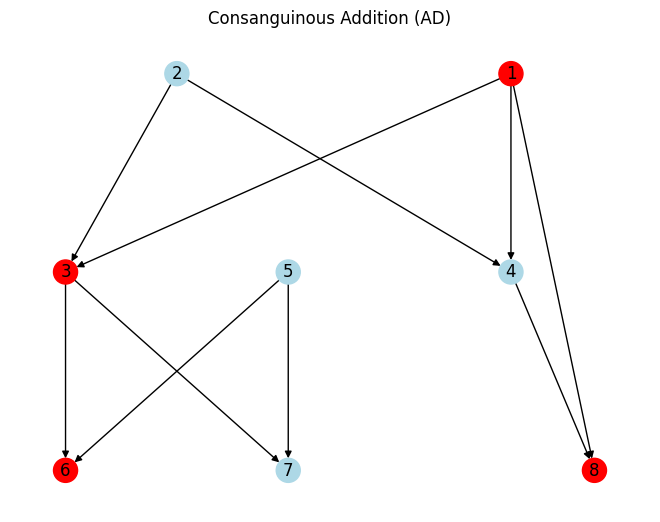

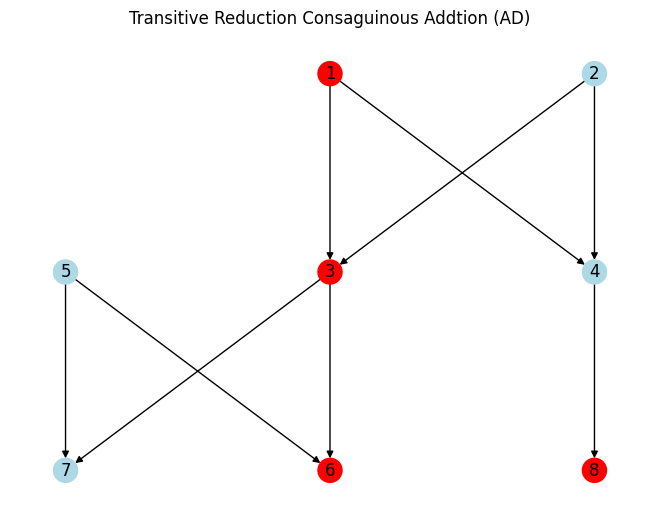

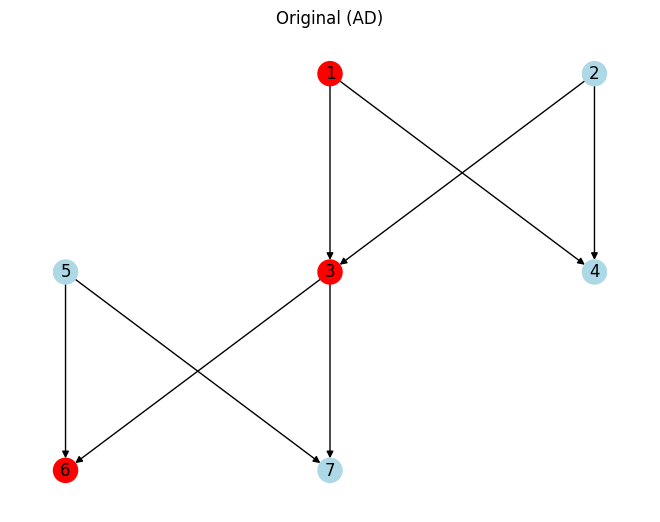

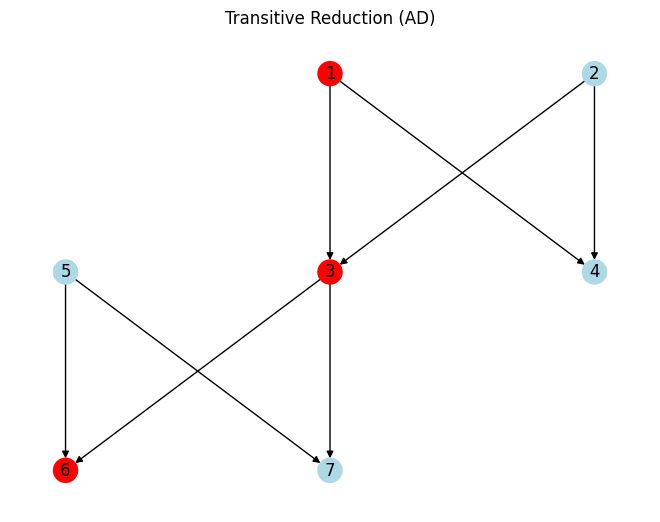

NameError: name 'dag_summary' is not defined

In [87]:
testG_AD = copy.deepcopy(G_ad)
testG_AD.add_node(8, family='FAM1', sex=1, phenotype=2)
testG_AD.add_edge(1, 8)
testG_AD.add_edge(4, 8)

test_trG_AD = nx.transitive_reduction(testG_AD)
test_trG_AD.add_nodes_from(testG_AD.nodes(data=True))
test_trG_AD.add_edges_from((u, v, testG_AD.edges[u,v]) for u, v in test_trG_AD.edges)

plot_pedigree_tree(testG_AD, title="Consanguinous Addition (AD)")
plot_pedigree_tree(test_trG_AD, title="Transitive Reduction Consaguinous Addtion (AD)")


trG_AD = nx.transitive_reduction(G_ad)
trG_AD.add_nodes_from(G_ad.nodes(data=True))
trG_AD.add_edges_from((u, v, G_ad.edges[u,v]) for u, v in trG_AD.edges)

plot_pedigree_tree(G_ad, title="Original (AD)")
plot_pedigree_tree(trG_AD, title="Transitive Reduction (AD)")

pprint(dag_summary(G_ad))

In [ ]:
# ---------------------------------------------------------------------
# 1v1. Original Edge Consistency Scoring
# ---------------------------------------------------------------------
def old_edge_consistency(G, gt, mode="AD"):
    """
    Fraction of parent→child edges whose genotype transition is Mendelian-
    compatible under the specified inheritance mode.
    gt is a dict {node: 0/1/2}.
    """
    ALLOWED_INHERITENCE = {
        'AD': {(0,0):{0}, (1,0):{0,1}, (0,1):{0,1}, (1,1):{0,1,2}, (2,_):{1,2}},
        'AR': {(0,0):{0}, (1,0):{0,1}, (0,1):{0,1}, (1,1):{0,1,2}, (2,_):{1,2}},
    }
    good=0; total=0
    for child in G:
        prnts=parents(G,child)
        gp,gm=[gt.get(p,0) for p in prnts+[0,0]][:2]
        par_gt = (gp,gm) if (gp,gm) in ALLOWED_INHERITENCE[mode] else (gm,gp)
        par_gt = (2,_) if par_gt not in ALLOWED_INHERITENCE[mode] else par_gt
        if gt[child] in ALLOWED_INHERITENCE[mode][par_gt]:
            good+=1
        total+=1
    return good/total

In [ ]:
# ---------------------------------------------------------------------
# 3v1. Carrier Betweeness
# ---------------------------------------------------------------------
'''
Currently defunct so as to trial subgraph version that prunes graph to affected nodes and carriers
'''
def old_carrier_betweenness(G, gt):
    phen = nx.get_node_attributes(G, "phenotype")
    het_car=[n for n in G if gt[n]==1 and phen[n]!=2]

    if het_car:
        bet = nx.betweenness_centrality(G)
        cb = sum(bet[n] for n in het_car)/len(het_car)
        cb /= max(bet.values()) if bet else 1
        return cb
    else:
        return 0